### Importing Required Libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import opendatasets as od

### Dowloading Data Set [fer2013]

In [5]:
od.download("https://www.kaggle.com/datasets/msambare/fer2013",data_dir="../Data_Set/")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013


100%|██████████| 60.3M/60.3M [04:10<00:00, 252kB/s]


### Get the shape of the image

In [2]:
img_array = cv2.imread("../Data_Set/fer2013/train/angry/Training_3908.jpg")
img_array.shape

(48, 48, 3)

Hense image is RGB image due to the three channels

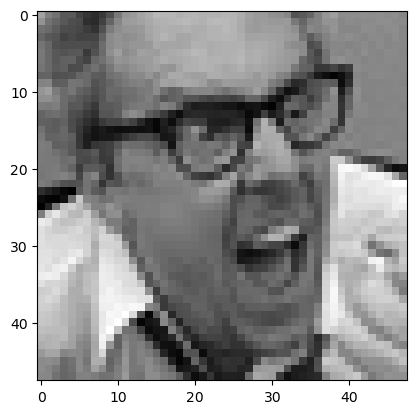

In [3]:
plt.imshow(img_array)  #RGB

In [4]:
train_data_dir ='../Data_Set/fer2013/train'
test_data_dir ='../Data_Set/fer2013/test'

In [5]:
BATCH_SIZE = 64
IMAGE_SIZE =(224,224)

### Spliting data into train, validation and test

In [6]:
train_data = tf.keras.utils.image_dataset_from_directory(train_data_dir,
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMAGE_SIZE,
                                                         subset='training',
                                                         validation_split=0.1,
                                                         seed=42)

validation_data = tf.keras.utils.image_dataset_from_directory(train_data_dir,
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMAGE_SIZE,
                                                         subset='validation',
                                                         validation_split=0.1,
                                                         seed=42)

test_data = tf.keras.utils.image_dataset_from_directory(test_data_dir,
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMAGE_SIZE)


Found 28709 files belonging to 7 classes.
Using 25839 files for training.
Found 28709 files belonging to 7 classes.
Using 2870 files for validation.
Found 7178 files belonging to 7 classes.


* For the Training used : 25839 images
* For the Validation used : 2870 images
* For the Testing used : 7178 images

Clsses of the trainning data

In [8]:
train_data.class_names

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

Classes of the testing data

In [7]:
test_data.class_names

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [8]:
# Determine the number of batches
num_batches = tf.data.experimental.cardinality(train_data).numpy()
print(f"Number of batches: {num_batches}")

Number of batches: 404


In [9]:
# Determine the total number of samples
num_samples = num_batches * BATCH_SIZE
print(f"Number of samples: {num_samples}")

Number of samples: 25856


### Training data set

In [10]:
for image_batch,label_batch in train_data.take(1):
  print(image_batch)
  print(label_batch)

tf.Tensor(
[[[[0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [7.14285374e-02 7.14285374e-02 7.14285374e-02]
   ...
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]]

  [[0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [7.14285374e-02 7.14285374e-02 7.14285374e-02]
   ...
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]]

  [[1.42857075e-01 1.42857075e-01 1.42857075e-01]
   [1.42857075e-01 1.42857075e-01 1.42857075e-01]
   [2.09183574e-01 2.09183574e-01 2.09183574e-01]
   ...
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]]

  ...

  [[1.10000000e+01 1.10000000e+01 1.10000000e+01]
   [1

### Testing data set

In [13]:
for image_batch,label_batch in test_data.take(1):
  print(image_batch)
  print(label_batch)

tf.Tensor(
[[[[0.0000000e+00 0.0000000e+00 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00]
   [3.5714269e-02 3.5714269e-02 3.5714269e-02]
   ...
   [0.0000000e+00 0.0000000e+00 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00]]

  [[0.0000000e+00 0.0000000e+00 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00]
   [3.5714269e-02 3.5714269e-02 3.5714269e-02]
   ...
   [0.0000000e+00 0.0000000e+00 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00]]

  [[0.0000000e+00 0.0000000e+00 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00]
   [3.4438759e-02 3.4438759e-02 3.4438759e-02]
   ...
   [0.0000000e+00 0.0000000e+00 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00]]

  ...

  [[8.9642868e+00 8.9642868e+00 8.9642868e+00]
   [8.9642868e+00 8.9642868e+00 8.9642868e+00]
   [8.9285727e+

In [14]:
for image_batch,label_batch in train_data.take(1):
  print(image_batch.shape)  # batch details
  print(label_batch.shape)  # no of labels in a batch

(64, 224, 224, 3)
(64,)


Normalizing data

In [11]:
train_data = train_data.map(lambda x,y:(x/255,y))
test_data = test_data.map(lambda x,y:(x/255,y))
validation_data = validation_data.map(lambda x,y:(x/255,y))

In [16]:
for image_batch,label_batch in train_data.take(1):
  print(image_batch)


tf.Tensor(
[[[[0.8235294  0.8235294  0.8235294 ]
   [0.8235294  0.8235294  0.8235294 ]
   [0.8127451  0.8127451  0.8127451 ]
   ...
   [0.6        0.6        0.6       ]
   [0.6        0.6        0.6       ]
   [0.6        0.6        0.6       ]]

  [[0.8235294  0.8235294  0.8235294 ]
   [0.8235294  0.8235294  0.8235294 ]
   [0.8127451  0.8127451  0.8127451 ]
   ...
   [0.6        0.6        0.6       ]
   [0.6        0.6        0.6       ]
   [0.6        0.6        0.6       ]]

  [[0.8215686  0.8215686  0.8215686 ]
   [0.8215686  0.8215686  0.8215686 ]
   [0.81079936 0.81079936 0.81079936]
   ...
   [0.59988    0.59988    0.59988   ]
   [0.5998599  0.5998599  0.5998599 ]
   [0.5998599  0.5998599  0.5998599 ]]

  ...

  [[0.8861345  0.8861345  0.8861345 ]
   [0.8861345  0.8861345  0.8861345 ]
   [0.88614446 0.88614446 0.88614446]
   ...
   [0.8163515  0.8163515  0.8163515 ]
   [0.8162465  0.8162465  0.8162465 ]
   [0.8162465  0.8162465  0.8162465 ]]

  [[0.8862745  0.8862745  0.886274

### Transfer Learning

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [18]:
model = tf.keras.applications.MobileNetV2()   # Pre- trained model

In [19]:
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

Model Tuning

In [20]:
base_input = model.layers[1].input
base_input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>

In [21]:
base_output = model.layers[-2].output
base_output

<KerasTensor: shape=(None, 1280) dtype=float32 (created by layer 'global_average_pooling2d')>

### Model Building

In [22]:
final_output = keras.layers.Dense(128)(base_output)
final_output = layers.Activation('relu')(final_output)
final_output = keras.layers.Dense(64)(final_output)
final_output = layers.Activation('relu')(final_output)
final_output = keras.layers.Dense(7,activation='softmax')(final_output)

In [23]:
final_output


<KerasTensor: shape=(None, 7) dtype=float32 (created by layer 'dense_2')>

In [24]:
new_model = keras.Model(inputs=base_input,outputs= final_output)

## Compile model

In [25]:
new_model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

## Model training

In [ ]:
history=new_model.fit(train_data,
                      validation_data=validation_data,
                      epochs=15
        )

Epoch 1/15




  3/449 [..............................] - ETA: 2:47:34 - loss: 2.0181 - accuracy: 0.1823

In [ ]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend()
plt.show()

In [ ]:

fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend()
plt.show()

In [ ]:
new_model.save("face_emotion.h5")

In [80]:
final_model = tf.keras.models.load_model("./face_emotion.h5")

In [96]:
img_path = "../Data_Set/fer2013/Happy.jpeg"
img = cv2.imread(img_path)
img.shape


(192, 204, 3)

In [97]:
resized_image = tf.image.resize(img, IMAGE_SIZE)
scaled_image = resized_image/255

In [98]:
# np.expand_dims(scaled_image, 0).shape

In [99]:
prediction=final_model.predict(np.expand_dims(scaled_image, 0))
prediction

1/1 [==============================] - 0s 138ms/step


array([[2.5452247e-02, 8.3516406e-06, 1.6921422e-05, 9.7183663e-01,
        2.4795523e-03, 1.9137709e-05, 1.8715783e-04]], dtype=float32)

Happy


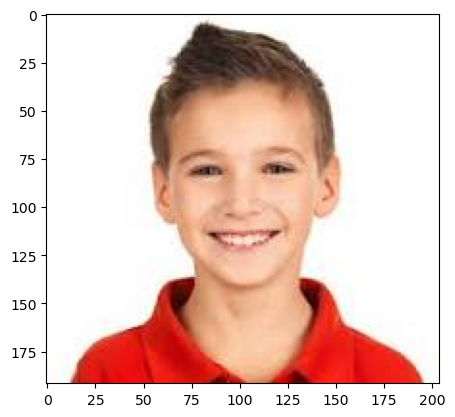

In [100]:
label = np.argmax(prediction)

if label == 0:
  print("Angry")
elif label == 1:
  print("Disgust")
elif label ==2:
  print("Fear")
elif label ==3:
  print("Happy")
elif label ==4:
  print("Neutral")
elif label ==5:
  print("Sad")
elif label ==6:
  print("Suprise")

plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))